# Method 8 - Rest Ideas After 5

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 5].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

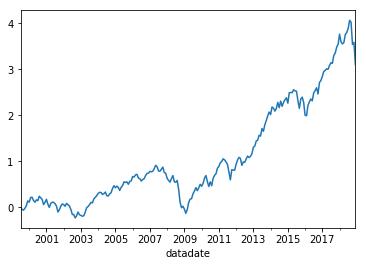

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.140196
2000-12-31   -0.026742
2001-12-31   -0.032586
2002-12-31   -0.218070
2003-12-31    0.494505
2004-12-31    0.172665
2005-12-31    0.070514
2006-12-31    0.107419
2007-12-31   -0.000599
2008-12-31   -0.411952
2009-12-31    0.465287
2010-12-31    0.233224
2011-12-31   -0.023733
2012-12-31    0.195815
2013-12-31    0.420604
2014-12-31    0.100277
2015-12-31   -0.028374
2016-12-31    0.144162
2017-12-31    0.209866
2018-12-31   -0.096889
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2725.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.66e-192
Time:                        07:20:42   Log-Likelihood:                 820.45
No. Observations:                 234   AIC:                            -1631.
Df Residuals:                     229   BIC:                            -1614.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      4.658      0.000       0.001       0.003
mktrf          1.0203      0.014     74.523      0.000       0.993       1.047
me             0.3060      0.016     19.216      0.000       0.275       0.337
ia             0.0835      0.024      3.449      0.001       0.036       0.131
roe           -0.1153      0.021     -5.565      0.000      -0.156      -0.074
==============================================================================
Omnibus:                       30.003   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.326
Skew:                           0.001   Prob(JB):                     9.42e-41
Kurtosis:                       7.348   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2038.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.11e-177
Time:                        07:20:42   Log-Likelihood:                 820.45
No. Observations:                 234   AIC:                            -1631.
Df Residuals:                     229   BIC:                            -1614.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      4.365      0.000       0.001       0.003
mktrf          1.0203      0.016     64.251      0.000       0.989       1.051
me             0.3060      0.030     10.095      0.000       0.247       0.365
ia             0.0835      0.046      1.820      0.069      -0.006       0.173
roe           -0.1153      0.033     -3.543      0.000      -0.179      -0.052
==============================================================================
Omnibus:                       30.003   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.326
Skew:                           0.001   Prob(JB):                     9.42e-41
Kurtosis:                       7.348   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2518.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.92e-188
Time:                        07:20:42   Log-Likelihood:                 820.45
No. Observations:                 234   AIC:                            -1631.
Df Residuals:                     229   BIC:                            -1614.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      4.398      0.000       0.001       0.003
mktrf          1.0203      0.016     64.790      0.000       0.989       1.051
me             0.3060      0.030     10.131      0.000       0.247       0.365
ia             0.0835      0.047      1.771      0.077      -0.009       0.176
roe           -0.1153      0.036     -3.182      0.001      -0.186      -0.044
==============================================================================
Omnibus:                       30.003   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.326
Skew:                           0.001   Prob(JB):                     9.42e-41
Kurtosis:                       7.348   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1779.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.01e-180
Time:                        07:20:42   Log-Likelihood:                 797.70
No. Observations:                 234   AIC:                            -1583.
Df Residuals:                     228   BIC:                            -1563.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.416      0.001       0.001       0.003
mktrf          1.0453      0.015     68.991      0.000       1.015       1.075
smb            0.3417      0.020     17.092      0.000       0.302       0.381
hml            0.0420      0.024      1.782      0.076      -0.004       0.088
rmw           -0.0640      0.027     -2.400      0.017      -0.116      -0.011
cma            0.0549      0.034      1.620      0.107      -0.012       0.122
==============================================================================
Omnibus:                       37.142   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              220.040
Skew:                           0.366   Prob(JB):                     1.66e-48
Kurtosis:                       7.694   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1454.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.01e-170
Time:                        07:20:42   Log-Likelihood:                 797.70
No. Observations:                 234   AIC:                            -1583.
Df Residuals:                     228   BIC:                            -1563.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.239      0.001       0.001       0.003
mktrf          1.0453      0.017     60.276      0.000       1.011       1.079
smb            0.3417      0.030     11.444      0.000       0.283       0.400
hml            0.0420      0.050      0.833      0.405      -0.057       0.141
rmw           -0.0640      0.035     -1.852      0.064      -0.132       0.004
cma            0.0549      0.046      1.190      0.234      -0.036       0.145
==============================================================================
Omnibus:                       37.142   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              220.040
Skew:                           0.366   Prob(JB):                     1.66e-48
Kurtosis:                       7.694   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1873.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.62e-183
Time:                        07:20:42   Log-Likelihood:                 797.70
No. Observations:                 234   AIC:                            -1583.
Df Residuals:                     228   BIC:                            -1563.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.102      0.002       0.001       0.003
mktrf          1.0453      0.017     61.966      0.000       1.012       1.078
smb            0.3417      0.029     11.625      0.000       0.284       0.399
hml            0.0420      0.051      0.829      0.407      -0.057       0.141
rmw           -0.0640      0.039     -1.633      0.102      -0.141       0.013
cma            0.0549      0.043      1.269      0.205      -0.030       0.140
==============================================================================
Omnibus:                       37.142   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              220.040
Skew:                           0.366   Prob(JB):                     1.66e-48
Kurtosis:                       7.694   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     2125.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.01e-179
Time:                        07:20:42   Log-Likelihood:                 792.05
No. Observations:                 234   AIC:                            -1574.
Df Residuals:                     229   BIC:                            -1557.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.807      0.000       0.001       0.003
mktrf          1.0306      0.014     72.420      0.000       1.003       1.059
smb            0.3621      0.018     20.385      0.000       0.327       0.397
hml            0.0994      0.018      5.631      0.000       0.065       0.134
umd           -0.0537      0.012     -4.642      0.000      -0.077      -0.031
==============================================================================
Omnibus:                       26.115   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.651
Skew:                           0.171   Prob(JB):                     6.32e-27
Kurtosis:                       6.501   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1848.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.84e-173
Time:                        07:20:42   Log-Likelihood:                 792.05
No. Observations:                 234   AIC:                            -1574.
Df Residuals:                     229   BIC:                            -1557.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.146      0.002       0.001       0.003
mktrf          1.0306      0.019     55.622      0.000       0.994       1.067
smb            0.3621      0.025     14.626      0.000       0.314       0.411
hml            0.0994      0.049      2.039      0.041       0.004       0.195
umd           -0.0537      0.022     -2.423      0.015      -0.097      -0.010
==============================================================================
Omnibus:                       26.115   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.651
Skew:                           0.171   Prob(JB):                     6.32e-27
Kurtosis:                       6.501   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     2311.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.90e-184
Time:                        07:20:43   Log-Likelihood:                 792.05
No. Observations:                 234   AIC:                            -1574.
Df Residuals:                     229   BIC:                            -1557.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.018      0.003       0.001       0.003
mktrf          1.0306      0.016     65.054      0.000       1.000       1.062
smb            0.3621      0.026     13.848      0.000       0.311       0.413
hml            0.0994      0.054      1.848      0.065      -0.006       0.205
umd           -0.0537      0.018     -2.986      0.003      -0.089      -0.018
==============================================================================
Omnibus:                       26.115   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.651
Skew:                           0.171   Prob(JB):                     6.32e-27
Kurtosis:                       6.501   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1202.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.76e-93
Time:                        07:20:43   Log-Likelihood:                 400.41
No. Observations:                 120   AIC:                            -790.8
Df Residuals:                     115   BIC:                            -776.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.804      0.000       0.002       0.005
mktrf          1.0209      0.023     45.072      0.000       0.976       1.066
me             0.2789      0.022     12.467      0.000       0.235       0.323
ia             0.1265      0.035      3.611      0.000       0.057       0.196
roe           -0.1272      0.031     -4.103      0.000      -0.189      -0.066
==============================================================================
Omnibus:                       10.860   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               28.402
Skew:                          -0.054   Prob(JB):                     6.80e-07
Kurtosis:                       5.381   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1262.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.74e-94
Time:                        07:20:43   Log-Likelihood:                 400.41
No. Observations:                 120   AIC:                            -790.8
Df Residuals:                     115   BIC:                            -776.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.490      0.000       0.001       0.005
mktrf          1.0209      0.025     40.211      0.000       0.971       1.071
me             0.2789      0.032      8.829      0.000       0.217       0.341
ia             0.1265      0.050      2.540      0.011       0.029       0.224
roe           -0.1272      0.039     -3.222      0.001      -0.205      -0.050
==============================================================================
Omnibus:                       10.860   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               28.402
Skew:                          -0.054   Prob(JB):                     6.80e-07
Kurtosis:                       5.381   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2171.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.78e-107
Time:                        07:20:43   Log-Likelihood:                 400.41
No. Observations:                 120   AIC:                            -790.8
Df Residuals:                     115   BIC:                            -776.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.388      0.001       0.001       0.005
mktrf          1.0209      0.023     44.633      0.000       0.976       1.066
me             0.2789      0.032      8.599      0.000       0.215       0.342
ia             0.1265      0.044      2.856      0.004       0.040       0.213
roe           -0.1272      0.042     -3.005      0.003      -0.210      -0.044
==============================================================================
Omnibus:                       10.860   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               28.402
Skew:                          -0.054   Prob(JB):                     6.80e-07
Kurtosis:                       5.381   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     759.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.75e-86
Time:                        07:20:43   Log-Likelihood:                 387.12
No. Observations:                 120   AIC:                            -762.2
Df Residuals:                     114   BIC:                            -745.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.377      0.001       0.001       0.005
mktrf          1.0843      0.027     40.462      0.000       1.031       1.137
smb            0.3332      0.030     10.978      0.000       0.273       0.393
hml            0.0231      0.037      0.621      0.536      -0.051       0.097
rmw           -0.0362      0.044     -0.826      0.411      -0.123       0.051
cma            0.1177      0.048      2.450      0.016       0.023       0.213
==============================================================================
Omnibus:                       15.009   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               51.468
Skew:                           0.176   Prob(JB):                     6.67e-12
Kurtosis:                       6.189   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     907.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.01e-90
Time:                        07:20:43   Log-Likelihood:                 387.12
No. Observations:                 120   AIC:                            -762.2
Df Residuals:                     114   BIC:                            -745.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.253      0.001       0.001       0.005
mktrf          1.0843      0.034     32.046      0.000       1.018       1.151
smb            0.3332      0.044      7.622      0.000       0.248       0.419
hml            0.0231      0.083      0.278      0.781      -0.140       0.186
rmw           -0.0362      0.065     -0.553      0.580      -0.165       0.092
cma            0.1177      0.054      2.172      0.030       0.012       0.224
==============================================================================
Omnibus:                       15.009   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               51.468
Skew:                           0.176   Prob(JB):                     6.67e-12
Kurtosis:                       6.189   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1508.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.40e-102
Time:                        07:20:43   Log-Likelihood:                 387.12
No. Observations:                 120   AIC:                            -762.2
Df Residuals:                     114   BIC:                            -745.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.236      0.001       0.001       0.005
mktrf          1.0843      0.033     33.048      0.000       1.020       1.149
smb            0.3332      0.044      7.590      0.000       0.247       0.419
hml            0.0231      0.086      0.269      0.788      -0.145       0.192
rmw           -0.0362      0.073     -0.499      0.618      -0.178       0.106
cma            0.1177      0.050      2.338      0.019       0.019       0.216
==============================================================================
Omnibus:                       15.009   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               51.468
Skew:                           0.176   Prob(JB):                     6.67e-12
Kurtosis:                       6.189   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     895.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.24e-85
Time:                        07:20:43   Log-Likelihood:                 383.22
No. Observations:                 120   AIC:                            -756.4
Df Residuals:                     115   BIC:                            -742.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.775      0.000       0.002       0.005
mktrf          1.0418      0.023     45.241      0.000       0.996       1.087
smb            0.3561      0.026     13.584      0.000       0.304       0.408
hml            0.1205      0.026      4.588      0.000       0.068       0.172
umd           -0.0547      0.016     -3.379      0.001      -0.087      -0.023
==============================================================================
Omnibus:                       10.425   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               26.463
Skew:                           0.008   Prob(JB):                     1.79e-06
Kurtosis:                       5.301   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1129.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.00e-91
Time:                        07:20:43   Log-Likelihood:                 383.22
No. Observations:                 120   AIC:                            -756.4
Df Residuals:                     115   BIC:                            -742.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.817      0.000       0.002       0.005
mktrf          1.0418      0.030     34.690      0.000       0.983       1.101
smb            0.3561      0.030     11.842      0.000       0.297       0.415
hml            0.1205      0.062      1.937      0.053      -0.001       0.242
umd           -0.0547      0.026     -2.078      0.038      -0.106      -0.003
==============================================================================
Omnibus:                       10.425   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               26.463
Skew:                           0.008   Prob(JB):                     1.79e-06
Kurtosis:                       5.301   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1599.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.15e-100
Time:                        07:20:43   Log-Likelihood:                 383.22
No. Observations:                 120   AIC:                            -756.4
Df Residuals:                     115   BIC:                            -742.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.860      0.000       0.002       0.005
mktrf          1.0418      0.024     43.938      0.000       0.995       1.088
smb            0.3561      0.032     10.997      0.000       0.293       0.420
hml            0.1205      0.067      1.792      0.073      -0.011       0.252
umd           -0.0547      0.021     -2.616      0.009      -0.096      -0.014
==============================================================================
Omnibus:                       10.425   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               26.463
Skew:                           0.008   Prob(JB):                     1.79e-06
Kurtosis:                       5.301   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2490.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.11e-106
Time:                        07:20:43   Log-Likelihood:                 453.82
No. Observations:                 114   AIC:                            -897.6
Df Residuals:                     109   BIC:                            -884.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.594      0.000       0.001       0.003
mktrf          1.0160      0.014     74.804      0.000       0.989       1.043
me             0.3684      0.021     17.566      0.000       0.327       0.410
ia            -0.0566      0.029     -1.946      0.054      -0.114       0.001
roe           -0.1433      0.026     -5.606      0.000      -0.194      -0.093
==============================================================================
Omnibus:                        9.493   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.595
Skew:                          -0.698   Prob(JB):                      0.00825
Kurtosis:                       3.263   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     3292.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.18e-112
Time:                        07:20:43   Log-Likelihood:                 453.82
No. Observations:                 114   AIC:                            -897.6
Df Residuals:                     109   BIC:                            -884.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      4.026      0.000       0.001       0.002
mktrf          1.0160      0.012     88.337      0.000       0.993       1.039
me             0.3684      0.018     20.664      0.000       0.333       0.403
ia            -0.0566      0.030     -1.882      0.060      -0.116       0.002
roe           -0.1433      0.023     -6.266      0.000      -0.188      -0.098
==============================================================================
Omnibus:                        9.493   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.595
Skew:                          -0.698   Prob(JB):                      0.00825
Kurtosis:                       3.263   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     3607.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.41e-115
Time:                        07:20:43   Log-Likelihood:                 453.82
No. Observations:                 114   AIC:                            -897.6
Df Residuals:                     109   BIC:                            -884.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.931      0.000       0.001       0.002
mktrf          1.0160      0.011     89.872      0.000       0.994       1.038
me             0.3684      0.018     20.873      0.000       0.334       0.403
ia            -0.0566      0.033     -1.720      0.085      -0.121       0.008
roe           -0.1433      0.022     -6.592      0.000      -0.186      -0.101
==============================================================================
Omnibus:                        9.493   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.595
Skew:                          -0.698   Prob(JB):                      0.00825
Kurtosis:                       3.263   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2304.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.63e-108
Time:                        07:20:43   Log-Likelihood:                 462.55
No. Observations:                 114   AIC:                            -913.1
Df Residuals:                     108   BIC:                            -896.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.673      0.097      -0.000       0.002
mktrf          1.0247      0.012     85.010      0.000       1.001       1.049
smb            0.3444      0.020     17.597      0.000       0.306       0.383
hml            0.0185      0.025      0.743      0.459      -0.031       0.068
rmw           -0.1967      0.031     -6.438      0.000      -0.257      -0.136
cma           -0.0767      0.039     -1.978      0.051      -0.154       0.000
==============================================================================
Omnibus:                        7.688   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                7.545
Skew:                          -0.623   Prob(JB):                       0.0230
Kurtosis:                       3.187   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2084.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.20e-105
Time:                        07:20:43   Log-Likelihood:                 462.55
No. Observations:                 114   AIC:                            -913.1
Df Residuals:                     108   BIC:                            -896.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.703      0.089      -0.000       0.002
mktrf          1.0247      0.011     90.406      0.000       1.003       1.047
smb            0.3444      0.018     19.608      0.000       0.310       0.379
hml            0.0185      0.024      0.788      0.431      -0.028       0.065
rmw           -0.1967      0.029     -6.812      0.000      -0.253      -0.140
cma           -0.0767      0.043     -1.799      0.072      -0.160       0.007
==============================================================================
Omnibus:                        7.688   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                7.545
Skew:                          -0.623   Prob(JB):                       0.0230
Kurtosis:                       3.187   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     3322.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.74e-116
Time:                        07:20:43   Log-Likelihood:                 462.55
No. Observations:                 114   AIC:                            -913.1
Df Residuals:                     108   BIC:                            -896.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.499      0.134      -0.000       0.002
mktrf          1.0247      0.010    106.226      0.000       1.006       1.044
smb            0.3444      0.017     20.641      0.000       0.312       0.377
hml            0.0185      0.025      0.750      0.453      -0.030       0.067
rmw           -0.1967      0.029     -6.730      0.000      -0.254      -0.139
cma           -0.0767      0.048     -1.600      0.110      -0.171       0.017
==============================================================================
Omnibus:                        7.688   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                7.545
Skew:                          -0.623   Prob(JB):                       0.0230
Kurtosis:                       3.187   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     2073.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.89e-102
Time:                        07:20:43   Log-Likelihood:                 443.50
No. Observations:                 114   AIC:                            -877.0
Df Residuals:                     109   BIC:                            -863.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.762      0.448      -0.001       0.001
mktrf          1.0363      0.014     73.547      0.000       1.008       1.064
smb            0.3907      0.022     17.785      0.000       0.347       0.434
hml            0.0182      0.023      0.804      0.423      -0.027       0.063
umd           -0.0513      0.017     -3.004      0.003      -0.085      -0.017
==============================================================================
Omnibus:                        5.118   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                4.510
Skew:                          -0.440   Prob(JB):                        0.105
Kurtosis:                       3.418   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     1678.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.83e-97
Time:                        07:20:43   Log-Likelihood:                 443.50
No. Observations:                 114   AIC:                            -877.0
Df Residuals:                     109   BIC:                            -863.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.758      0.449      -0.001       0.001
mktrf          1.0363      0.015     70.072      0.000       1.007       1.065
smb            0.3907      0.020     19.280      0.000       0.351       0.430
hml            0.0182      0.024      0.764      0.445      -0.028       0.065
umd           -0.0513      0.014     -3.631      0.000      -0.079      -0.024
==============================================================================
Omnibus:                        5.118   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                4.510
Skew:                          -0.440   Prob(JB):                        0.105
Kurtosis:                       3.418   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     3260.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.00e-112
Time:                        07:20:43   Log-Likelihood:                 443.50
No. Observations:                 114   AIC:                            -877.0
Df Residuals:                     109   BIC:                            -863.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.731      0.465      -0.001       0.001
mktrf          1.0363      0.014     76.276      0.000       1.010       1.063
smb            0.3907      0.016     24.956      0.000       0.360       0.421
hml            0.0182      0.021      0.857      0.391      -0.023       0.060
umd           -0.0513      0.014     -3.775      0.000      -0.078      -0.025
==============================================================================
Omnibus:                        5.118   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                4.510
Skew:                          -0.440   Prob(JB):                        0.105
Kurtosis:                       3.418   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""